<a href="https://colab.research.google.com/github/samarthnayak04/chest-xray-pneumonia/blob/dl/pneumonia_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
from tensorflow import keras

# Model building blocks
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import plot_model
from IPython.display import Image, display
# Data preprocessing and augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Pre-trained model (our foundation)
from tensorflow.keras.applications import ResNet50

# Evaluation and visualization
from sklearn.metrics import (precision_recall_curve, roc_curve, accuracy_score,
                           confusion_matrix, precision_score, recall_score,
                           classification_report, roc_auc_score)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os


In [4]:
tf.random.set_seed(42)
np.random.seed(42)

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
base_dir = '/content/drive/My Drive/chest_xray'

train_dir = f'{base_dir}/train'
val_dir = f'{base_dir}/val'
test_dir = f'{base_dir}/test'

print(train_dir)
print(os.path.exists(train_dir))

print(os.listdir(train_dir))  # Should show ['NORMAL', 'PNEUMONIA']


/content/drive/My Drive/chest_xray/train
True
['PNEUMONIA', 'NORMAL']


In [8]:
# Data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [9]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model

# Build base properly
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # freeze initially

# Functional wiring (correct)
inputs = Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)  # call base_model as a layer
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(1, activation='sigmoid')(x)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [10]:
model = Model(inputs=inputs, outputs=outputs)

from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(learning_rate=1e-3),
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,112,513 (91.98 MB)

 Trainable params: 524,801 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [15]:

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)
checkpoint = ModelCheckpoint("pneumonia_resnet50_classifier.keras",
                             monitor="val_accuracy",
                             mode="max",
                             save_best_only=True)

In [16]:
history = model.fit(
    train_generator,
    epochs=15,
    validation_data=val_generator,
    callbacks=[reduce_lr, checkpoint]
)

Epoch 1/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 22s/step - accuracy: 0.7319 - loss: 0.5893 

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


163/163 ━━━━━━━━━━━━━━━━━━━━ 3626s 22s/step - accuracy: 0.7320 - loss: 0.5892 - val_accuracy: 0.5000 - val_loss: 0.7845 - learning_rate: 0.0010
Epoch 2/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 197s 862ms/step - accuracy: 0.7400 - loss: 0.5332 - val_accuracy: 0.5000 - val_loss: 0.7416 - learning_rate: 0.0010
Epoch 3/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 140s 856ms/step - accuracy: 0.7550 - loss: 0.4837 - val_accuracy: 0.5000 - val_loss: 0.8595 - learning_rate: 0.0010
Epoch 4/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 142s 866ms/step - accuracy: 0.7607 - loss: 0.4759 - val_accuracy: 0.5625 - val_loss: 0.7180 - learning_rate: 0.0010
Epoch 5/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 141s 862ms/step - accuracy: 0.7683 - loss: 0.4494 - val_accuracy: 0.5625 - val_loss: 0.7368 - learning_rate: 0.0010
Epoch 6/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 139s 856ms/step - accuracy: 0.7747 - loss: 0.4259 - val_accuracy: 0.5625 - val_loss: 0.8572 - learning_rate: 0.0010
Epoch 7/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 138s 849ms/step - accuracy: 0.7886 -

In [17]:
normal_count = len(os.listdir(f'{train_dir}/NORMAL'))
pneumonia_count = len(os.listdir(f'{train_dir}/PNEUMONIA'))
total_samples = normal_count + pneumonia_count

class_weight = {
    0: total_samples / (2.0 * normal_count),      # Weight for NORMAL
    1: total_samples / (2.0 * pneumonia_count)    # Weight for PNEUMONIA
}

print("NORMAL images:", normal_count)
print("PNEUMONIA images:", pneumonia_count)
print("Total training samples:", total_samples)
print("Class weights:", class_weight)


NORMAL images: 1341
PNEUMONIA images: 3875
Total training samples: 5216
Class weights: {0: 1.9448173005219984, 1: 0.6730322580645162}


In [18]:
# Fine-tuning (unfreeze last layers)
base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

history_fine = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[ reduce_lr, checkpoint]
)


Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 170s 917ms/step - accuracy: 0.8051 - loss: 0.4314 - val_accuracy: 0.5000 - val_loss: 1.8775 - learning_rate: 1.0000e-04
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 146s 897ms/step - accuracy: 0.8475 - loss: 0.3284 - val_accuracy: 0.5625 - val_loss: 3.7524 - learning_rate: 1.0000e-04
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 147s 904ms/step - accuracy: 0.8770 - loss: 0.2919 - val_accuracy: 0.5000 - val_loss: 3.6430 - learning_rate: 1.0000e-04
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 149s 912ms/step - accuracy: 0.8897 - loss: 0.2451 - val_accuracy: 0.5625 - val_loss: 0.8995 - learning_rate: 1.0000e-04
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 146s 898ms/step - accuracy: 0.8946 - loss: 0.2517 - val_accuracy: 0.5000 - val_loss: 5.1915 - learning_rate: 1.0000e-04
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 146s 893ms/step - accuracy: 0.8923 - loss: 0.2422 - val_accuracy: 0.5000 - val_loss: 15.6849 - learning_rate: 1.0000e-04
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━

In [19]:
print(f"\n📊 Evaluating model on test set...")

# Get test predictions
test_generator.reset()
predictions = model.predict(test_generator)
predicted_classes = (predictions > 0.5).astype(int).flatten()

# Get true labels
true_labels = test_generator.classes

# Calculate metrics
accuracy = accuracy_score(true_labels, predicted_classes)
precision = precision_score(true_labels, predicted_classes)
recall = recall_score(true_labels, predicted_classes)
auc = roc_auc_score(true_labels, predictions)

print(f"\n🎯 TEST RESULTS:")
print("=" * 30)
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"AUC-ROC:   {auc:.4f}")

# Classification report
print(f"\n📋 Detailed Classification Report:")
print(classification_report(true_labels, predicted_classes,
                          target_names=['Normal', 'Pneumonia']))


📊 Evaluating model on test set...
20/20 ━━━━━━━━━━━━━━━━━━━━ 406s 21s/step

🎯 TEST RESULTS:
Accuracy:  0.8365
Precision: 0.9286
Recall:    0.8000
AUC-ROC:   0.9204

📋 Detailed Classification Report:
              precision    recall  f1-score   support

      Normal       0.73      0.90      0.80       234
   Pneumonia       0.93      0.80      0.86       390

    accuracy                           0.84       624
   macro avg       0.83      0.85      0.83       624
weighted avg       0.85      0.84      0.84       624



In [33]:
model.save("pneumonia_resnet50_classifier.keras")
model.save("pneumonia_resnet50_classifier.h5")


In [34]:
from google.colab import files

files.download("/content/pneumonia_resnet50_classifier.h5")
files.download("/content/pneumonia_resnet50_classifier.keras")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [32]:
def plot_training_history(history, history_fine=None):
    """Plot training and validation metrics"""
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Combine histories if fine-tuning was done
    if history_fine:
        acc = history.history['accuracy'] + history_fine.history['accuracy']
        val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']
        loss = history.history['loss'] + history_fine.history['loss']
        val_loss = history.history['val_loss'] + history_fine.history['val_loss']
    else:
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']
        loss = history.history['loss']
        val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    # Accuracy plot
    axes[0].plot(epochs, acc, 'bo-', label='Training Accuracy')
    axes[0].plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
    axes[0].set_title('Training and Validation Accuracy')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(True)

    # Loss plot
    axes[1].plot(epochs, loss, 'bo-', label='Training Loss')
    axes[1].plot(epochs, val_loss, 'ro-', label='Validation Loss')
    axes[1].set_title('Training and Validation Loss')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()






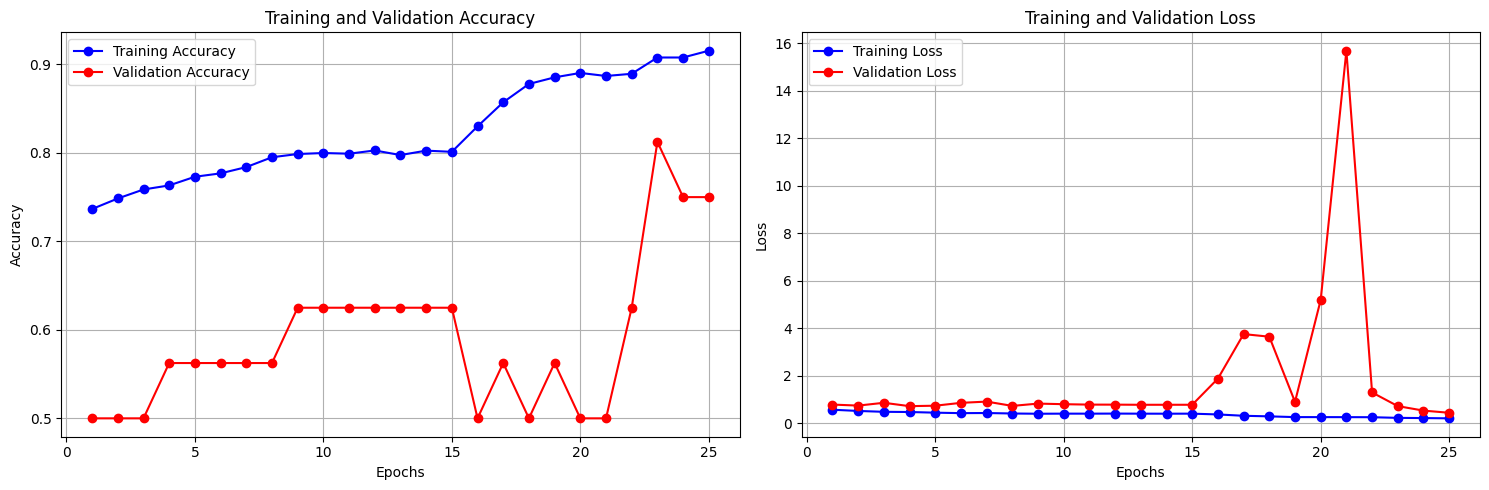

In [26]:
plot_training_history(history, history_fine)

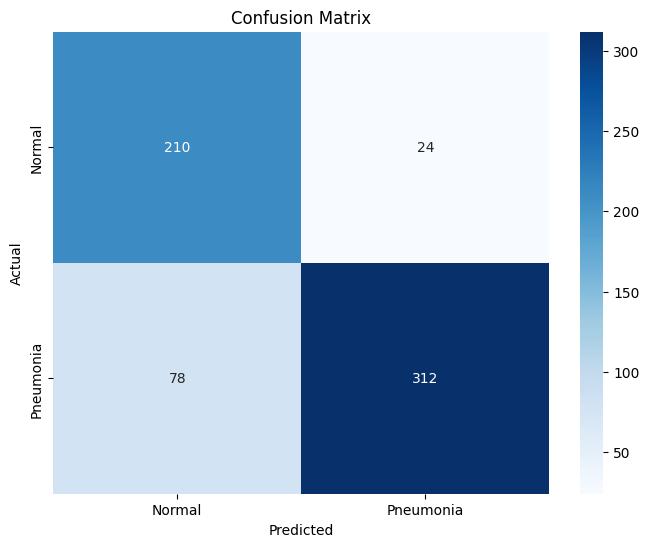

In [24]:
def plot_confusion_matrix(true_labels, predicted_classes):
    """Plot confusion matrix"""
    cm = confusion_matrix(true_labels, predicted_classes)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal', 'Pneumonia'],
                yticklabels=['Normal', 'Pneumonia'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
plot_confusion_matrix(true_labels, predicted_classes)

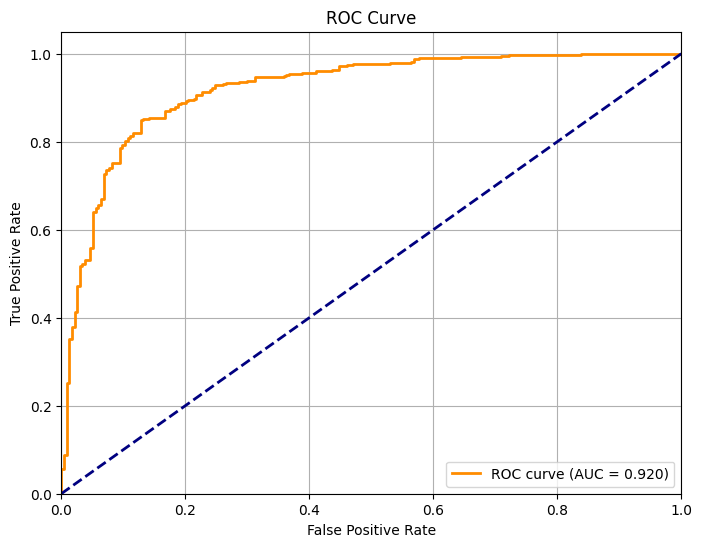

In [27]:
def plot_roc_curve(true_labels, predictions):
    """Plot ROC curve"""
    fpr, tpr, _ = roc_curve(true_labels, predictions)
    auc = roc_auc_score(true_labels, predictions)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2,
             label=f'ROC curve (AUC = {auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()
plot_roc_curve(true_labels, predictions)



🖼️ Showing sample predictions...
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


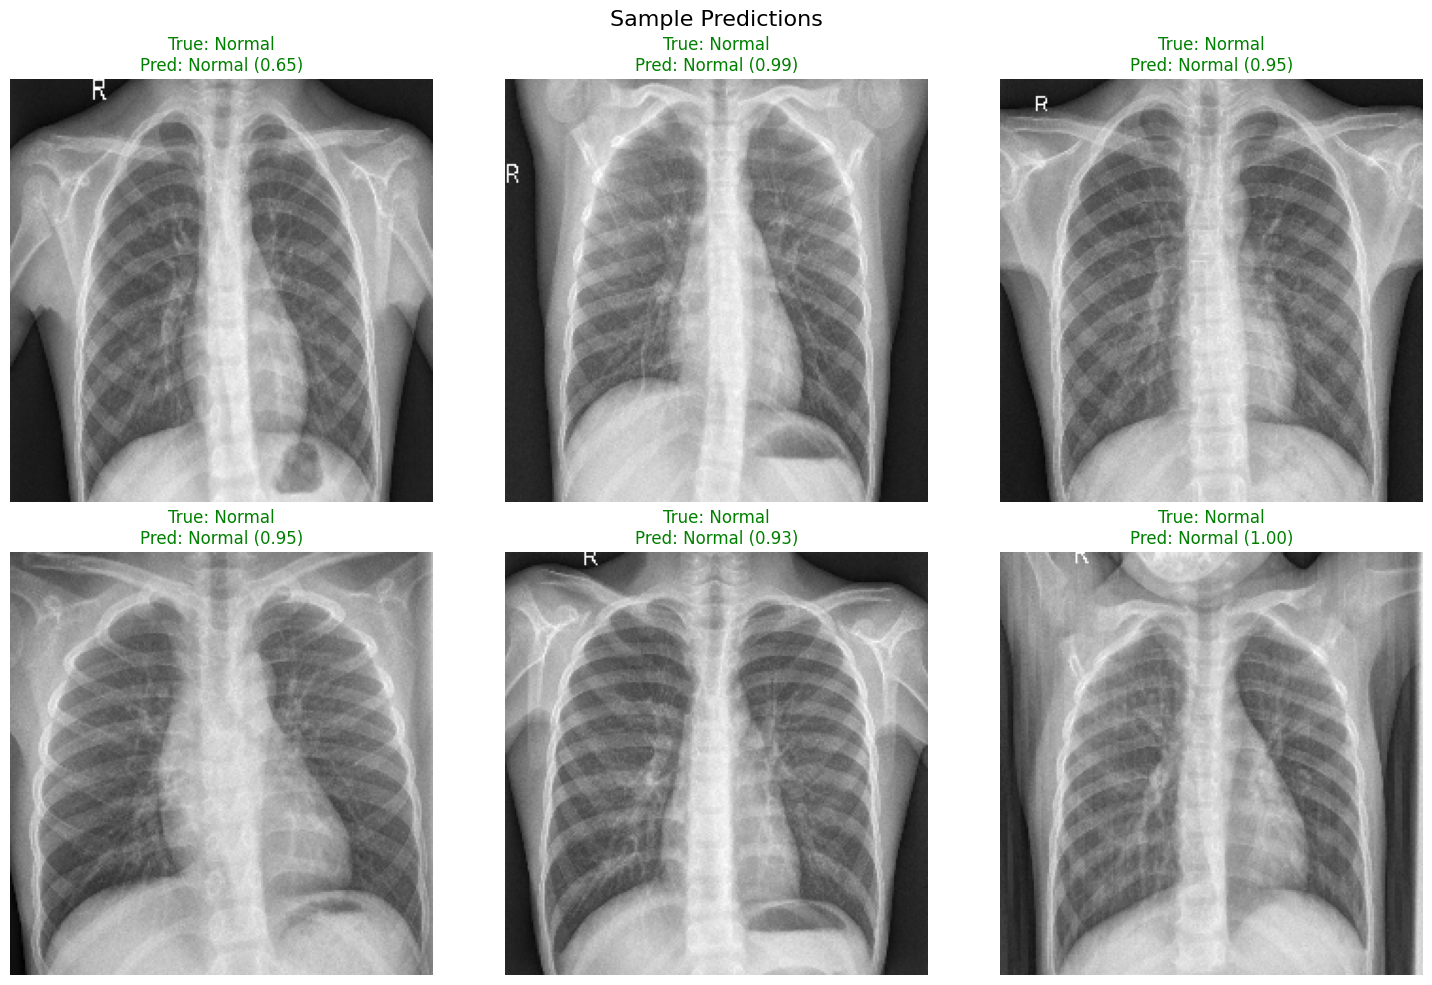

In [28]:
def show_sample_predictions(generator, model, num_samples=6):
    """Show sample predictions with images"""
    generator.reset()
    batch_images, batch_labels = next(generator)
    predictions = model.predict(batch_images)

    plt.figure(figsize=(15, 10))
    for i in range(min(num_samples, len(batch_images))):
        plt.subplot(2, 3, i+1)
        plt.imshow(batch_images[i])

        true_class = 'Pneumonia' if batch_labels[i] == 1 else 'Normal'
        pred_class = 'Pneumonia' if predictions[i] > 0.5 else 'Normal'
        confidence = predictions[i][0] if predictions[i] > 0.5 else 1-predictions[i][0]

        color = 'green' if true_class == pred_class else 'red'
        plt.title(f'True: {true_class}\nPred: {pred_class} ({confidence:.2f})',
                 color=color)
        plt.axis('off')

    plt.suptitle('Sample Predictions', fontsize=16)
    plt.tight_layout()
    plt.show()

print(f"\n🖼️ Showing sample predictions...")
show_sample_predictions(test_generator, model)

In [35]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np

# Load saved model (use .keras if possible)
# model = load_model("pneumonia_resnet50_classifier.keras", compile=False)
model1 = load_model("pneumonia_resnet50_classifier.h5", compile=False)

# Image path
img_path = "/content/drive/MyDrive/chest_xray/test/PNEUMONIA/person1_virus_6.jpeg"

# Preprocess the image
img = image.load_img(img_path, target_size=(224, 224))  # match training input size
img_array = image.img_to_array(img) / 255.0            # rescale
img_array = np.expand_dims(img_array, axis=0)          # add batch dimension

# Predict
# prediction = model.predict(img_array, verbose=0)[0][0]
prediction = model1.predict(img_array, verbose=0)[0][0]

if prediction > 0.5:
    print(f"Prediction: Pneumonia ({prediction*100:.2f}% confidence)")
else:
    print(f"Prediction: Normal ({(1-prediction)*100:.2f}% confidence)")


Prediction: Pneumonia (99.90% confidence)
